In [1]:
import pandas as pd
import torch
import os
import torch.nn.functional as F
import random
import torch.optim
import torch.nn as nn
import albumentations as A
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import pydicom
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from prettytable import PrettyTable
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
import cv2
import timm
from matplotlib.patches import Rectangle
from ipywidgets import interact, IntSlider

In [2]:
!pip install pylibjpeg
!pip install gdcm


  Obtaining dependency information for pylibjpeg from https://files.pythonhosted.org/packages/de/02/d5610461d3924f9d13be07442e1c3f45d210b52f25cda8ed7304081ec4e8/pylibjpeg-2.0.0-py3-none-any.whl.metadata


DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


^C


In [ ]:
pip install python-gdcm pylibjpeg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 74.3 MB/s eta 0:00:00:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [3]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
batch_size=64
EPOCHS=100
lr=1e-4
early_stopping_patience=20

  Obtaining dependency information for gdcm from https://files.pythonhosted.org/packages/ec/45/eb03dc3d3813a2840bddeb5eb91782de6d06c423aeed1ebaff462a083cf3/gdcm-1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB 65.6 kB/s eta 0:01:01
   ---------------------------------------- 0.0/4.0 MB 109.5 kB/s eta 0:00:37
   ---------------------------------------- 0.0/4.0 MB 109.5 kB/s eta 0:00:37
   ---------------

DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [8]:
!kaggle datasets download -d aishawaziry/dicom-thoracic-diseases-part1

Dataset URL: https://www.kaggle.com/datasets/aishawaziry/dicom-thoracic-diseases-part1
License(s): unknown
100%|█████████████████████████████████████▉| 2.40G/2.41G [00:33<00:00, 71.8MB/s]
100%|██████████████████████████████████████| 2.41G/2.41G [00:33<00:00, 77.4MB/s]


In [9]:
!kaggle datasets download -d aishawaziry/dicom-thoracic-diseases-part2

Dataset URL: https://www.kaggle.com/datasets/aishawaziry/dicom-thoracic-diseases-part2
License(s): unknown
 99%|██████████████████████████████████████▌| 2.25G/2.28G [00:16<00:00, 129MB/s]
100%|███████████████████████████████████████| 2.28G/2.28G [00:16<00:00, 148MB/s]


In [10]:
!kaggle datasets download -d aishawaziry/dicom-throtic-disease-part6

Dataset URL: https://www.kaggle.com/datasets/aishawaziry/dicom-throtic-disease-part6
License(s): unknown
 97%|███████████████████████████████████████▊ | 881M/907M [00:06<00:00, 128MB/s]
100%|█████████████████████████████████████████| 907M/907M [00:06<00:00, 151MB/s]


In [11]:
!kaggle datasets download -d aishawaziry/dicom-thoracic-disease-part4

Dataset URL: https://www.kaggle.com/datasets/aishawaziry/dicom-thoracic-disease-part4
License(s): unknown
 99%|██████████████████████████████████████▋| 1.86G/1.88G [00:12<00:00, 181MB/s]
100%|███████████████████████████████████████| 1.88G/1.88G [00:12<00:00, 161MB/s]


In [12]:
!unzip dicom-thoracic-diseases-part1

Archive:  dicom-thoracic-diseases-part1.zip
  inflating: Brocho-pneumonia/0008e7acbcdf2fedd05cc236e5594074.dicom  
  inflating: Brocho-pneumonia/00e898fc3a6a95d56510c5c87fdbc03a.dicom  
  inflating: Brocho-pneumonia/01e426d8246a6df3895e7aefce6e0b82.dicom  
  inflating: Brocho-pneumonia/029bc8f1be227a6e47ef1fa2b402318d.dicom  
  inflating: Brocho-pneumonia/0394d936a647a16dc0ecf4a4f5563133.dicom  
  inflating: Brocho-pneumonia/04698987828368bd67a38b55e29ffc9f.dicom  
  inflating: Brocho-pneumonia/04a3e61167d2f5471c02f116385e2cf8.dicom  
  inflating: Brocho-pneumonia/050de21b590399d9a909db0021cbee69.dicom  
  inflating: Brocho-pneumonia/050ffa833ea8ce757ff5d53e74e373e4.dicom  
  inflating: Brocho-pneumonia/0591f984b116fe03e995b4c2b1f4d5d5.dicom  
  inflating: Brocho-pneumonia/0645a34241b27e35ab22b1d7157fa6cf.dicom  
  inflating: Brocho-pneumonia/0674fb7decc2fc5a6c58a37572b4b77a.dicom  
  inflating: Brocho-pneumonia/06ec5781f1c9594970c39c76a51abe2d.dicom  
  inflating: Brocho-pneumonia/079

In [13]:
!unzip dicom-thoracic-diseases-part2

Archive:  dicom-thoracic-diseases-part2.zip
  inflating: train_img/009a3dd54bcfb144d12d29a3fb859582.dicom  
  inflating: train_img/00b818c3d77ae34a189558fdfc798006.dicom  
  inflating: train_img/0119beca31970c7d5293316a515d7ee9.dicom  
  inflating: train_img/014c0f6ffe36e32639726302f7ef3990.dicom  
  inflating: train_img/01b9c6193cfd9c247cad1b843a95aca7.dicom  
  inflating: train_img/01e1af657d2f490a08ba32793863e482.dicom  
  inflating: train_img/026a1ae71a7498c8837e1bef43961e94.dicom  
  inflating: train_img/02f0dd36aceadd16101c35b53c0f0667.dicom  
  inflating: train_img/031f3b78afcbd05c8034798ef06fa2b2.dicom  
  inflating: train_img/03f2f9897cec3c951c72429b395f37f7.dicom  
  inflating: train_img/0410ccc950217c2d2bace32cf8b8b6c4.dicom  
  inflating: train_img/0435de4ae0994ca42d05627e0c77ddf3.dicom  
  inflating: train_img/04935fa9ecc92a5fdd36aad05d4f9e59.dicom  
  inflating: train_img/04a54f373d7c4d36f13774a6ac7bcb65.dicom  
  inflating: train_img/04c4dfa1d44ba1487534e42ac084130f.dico

In [14]:
!unzip dicom-throtic-disease-part6

Archive:  dicom-throtic-disease-part6.zip
  inflating: Bronchiolitis/008000749ecc9074e80562f9f90091fd.dicom  
  inflating: Bronchiolitis/00e5c7c8c64dcf9c2b85f2d92d67a1e3.dicom  
  inflating: Bronchiolitis/01b386a829001d4c828f0364bc6f6c77.dicom  
  inflating: Bronchiolitis/020c34f8cfb3b044258791a1e69dd731.dicom  
  inflating: Bronchiolitis/02358b1c462e0fbc7b0560ddadd3985e.dicom  
  inflating: Bronchiolitis/03261eb57d5f1cf466e1eee862029ff3.dicom  
  inflating: Bronchiolitis/032a6cfa32465d088ef0e4d0a2827fe6.dicom  
  inflating: Bronchiolitis/033684cd409af22cd984aac6239d374d.dicom  
  inflating: Bronchiolitis/042bbc31cdc373bc017677ffc5853c85.dicom  
  inflating: Bronchiolitis/044a06d9137fe60a8d2e8038431764d0.dicom  
  inflating: Bronchiolitis/0571e9cee355f41b238a0c391a0d68a6.dicom  
  inflating: Bronchiolitis/0609b1fd3647577e8244882f90f15793.dicom  
  inflating: Bronchiolitis/069ba975266af0b01b173158384cf70b.dicom  
  inflating: Bronchiolitis/093ced13d4f5f822850e86f2bc5a3628.dicom  
  infl

In [15]:
!unzip dicom-thoracic-disease-part4

Archive:  dicom-thoracic-disease-part4.zip
  inflating: Bronchitis/014292fff49a4743b0bc9840002c6d79.dicom  
  inflating: Bronchitis/017fc14b3333578679134437da100e67.dicom  
  inflating: Bronchitis/01aca60ced6e10c6387901b1863fea21.dicom  
  inflating: Bronchitis/01bffcbd15363711155081fe1bae4599.dicom  
  inflating: Bronchitis/02047bf392b702eca2d44a1e0ca3839d.dicom  
  inflating: Bronchitis/0282d0094ca106b93da8372a74934697.dicom  
  inflating: Bronchitis/0359a500f7d864895f5fd93c7c40e45e.dicom  
  inflating: Bronchitis/03c02e5ee20ed4f61169aff1f1268f31.dicom  
  inflating: Bronchitis/03c511e33d87bad7ec181bf1098c12c8.dicom  
  inflating: Bronchitis/04054ce796a6210def5824805150f133.dicom  
  inflating: Bronchitis/043f99626ed97dbbb2c0365671c20428.dicom  
  inflating: Bronchitis/046a011bce34381981acb6cddb8da123.dicom  
  inflating: Bronchitis/0475034e3ef5a172cd6640085f329f64.dicom  
  inflating: Bronchitis/052b2ff22f4f6c2ee0dfdfd9afa2eb5e.dicom  
  inflating: Bronchitis/05ca7efbc57d622886c811b

In [16]:
#training dir
train_directories = [
    '/kaggle/working/train_img',
    '/kaggle/working/Brocho-pneumonia',
    '/kaggle/working/Bronchiolitis',
    '/kaggle/working/Bronchitis',
    '/kaggle/input/fk-dicom/Other disease_train',
    '/kaggle/input/fk-dicom/Pneumonia'
]
#test dir
test_directories = [
    '/kaggle/working/test_img',
    '/kaggle/working/Brocho-pneumonia_test',
    '/kaggle/working/Bronchiolitis_test',
    '/kaggle/working/Bronchitis_test',
    '/kaggle/working/Other disease_test',
    '/kaggle/working/Pneumonia_test'
]

In [17]:
# Define class labels train
class_labels_train = {
    '/kaggle/working/train_img': 0,
    '/kaggle/input/fk-dicom/Other disease_train': 1,
    '/kaggle/input/fk-dicom/Pneumonia': 2,
    '/kaggle/working/Bronchitis': 3,
    '/kaggle/working/Bronchiolitis': 4,
    '/kaggle/working/Brocho-pneumonia': 5
}
# Define class labels test
class_labels_test = {
    '/kaggle/working/test_img': 0,
    '/kaggle/working/Other disease_test': 1,
    '/kaggle/working/Pneumonia_test': 2,
    '/kaggle/working/Bronchitis_test': 3,
    '/kaggle/working/Bronchiolitis_test': 4,
    '/kaggle/working/Brocho-pneumonia_test': 5
}

In [18]:
def load_and_shuffle_with_label(directory_list, class_label):
    data = []
    for directory in directory_list:
        print(directory)
        label = class_label[directory]
        files = os.listdir(directory)
        random.shuffle(files)

        for file in files:
            file_path = os.path.join(directory, file)
            try:
                if not pydicom.misc.is_dicom(file_path):
                    print(f"Skipping file {file_path}: Not a valid DICOM file.")
                    continue
                # Attempt to load the DICOM file
                dicom = pydicom.dcmread(file_path)
                image = dicom.pixel_array
                data.append((file_path, label))
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                # Skip the file if an error occurs during loading
                continue
    random.shuffle(data)
    return data


In [19]:
# Load and shuffle train and test data with labels
train_data = load_and_shuffle_with_label(train_directories,class_labels_train)
test_data = load_and_shuffle_with_label(test_directories,class_labels_test)

/kaggle/working/train_img
Error loading /kaggle/working/train_img/d551b439b43e1a338f094724049ca7e3.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/train_img/45031ad9021c07aeaaee3114abf1870e.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/train_img/5c8536cb9f54599474e3d03d974843c1.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/train_img/7c887778f91815d602b8b187e63ef397.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/train_img/64c3b731f9e3a48ef62cb310c85e30c3.dicom: The fo

/opt/conda/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Error loading /kaggle/working/Bronchitis/e3642ba030ab263fafdad6299af79c7b.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/Bronchitis/f97e9c80583187ffeecfe51bea6ad7d1.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/Bronchitis/dfd44c977bdadd0ddb3b62015d599544.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/Bronchitis/65e8673d56d53956888a575de640358b.dicom: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )
Error loading /kaggle/working/Bronchitis/24127e4d62442947c867eef2c9708d11.dicom: The following handlers are 

In [20]:
print("Train Data:")
for sample in train_data[:5]:
    print(sample)

print("\nTest Data:")
for sample in test_data[:5]:
    print(sample)

Train Data:
('/kaggle/working/Bronchiolitis/6ad02307d7483a79a0f97e7c247db3f2.dicom', 4)
('/kaggle/input/fk-dicom/Other disease_train/620f54c7a555130927544779dfd10e1f.dicom', 1)
('/kaggle/working/train_img/0900784ebab5323f220a51e9f5a05bb8.dicom', 0)
('/kaggle/working/Brocho-pneumonia/472094101cb6e1882fd5245b08e64dd1.dicom', 5)
('/kaggle/input/fk-dicom/Other disease_train/0d7a56dc8e3586dd1e2f158240836fda.dicom', 1)

Test Data:
('/kaggle/working/Brocho-pneumonia_test/903cb71aa37bb12f426e03b962022686.dicom', 5)
('/kaggle/working/Bronchitis_test/a50bf19ef674805de9483fed10948be3.dicom', 3)
('/kaggle/working/Bronchitis_test/21cb454e57e58993a5b4c17f8e02c1da.dicom', 3)
('/kaggle/working/test_img/5ad499af22dec3a56019119b09ee65c2.dicom', 0)
('/kaggle/working/Pneumonia_test/1e1a82658113ff29ee4dd52b493183be.dicom', 2)


In [21]:
print(f"Length of Train Data: {len(train_data)}, Length of Test Data: {len(test_data)}")

Length of Train Data: 2404, Length of Test Data: 488


In [22]:
labels = [label[1] for label in train_data]

In [23]:
label_counts = {}
for label in labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

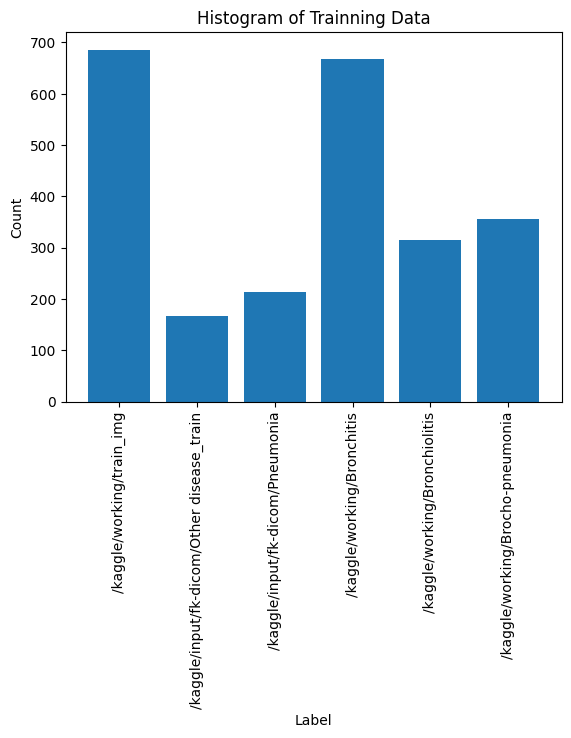

In [24]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Trainning Data')
plt.xticks(list(class_labels_train.values()), class_labels_train.keys(),rotation=90)  # Set x-axis labels according to the class labels
plt.show()

****Function to see best rectangle to be cropped****

In [25]:
def apply_crop_and_display(top_left_x, top_left_y, width, height, image_index):
    dicom_path = test_data[image_index][0]
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array
    
    # Apply the crop
    cropped_image = image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
    
    # Display the cropped image
    plt.imshow(cropped_image, cmap='gray')
    plt.title('Cropped Image')
    plt.axis('off')
    
    # Highlight the selected crop region with a rectangle
    rect = Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    
    plt.show()

In [26]:
top_left_x_slider = IntSlider(min=0, max=1500, step=5, value=0, description='Top Left X')
top_left_y_slider = IntSlider(min=0, max=1500, step=5, value=0, description='Top Left Y')
width_slider = IntSlider(min=1, max=1500, step=5, value=100, description='Width')
height_slider = IntSlider(min=1, max=1500
, step=5, value=100, description='Height')
image_index_slider = IntSlider(min=0, max=len(test_data)-1, step=1, value=0, description='Image Index')

interact(apply_crop_and_display, 
         top_left_x=top_left_x_slider, 
         top_left_y=top_left_y_slider, 
         width=width_slider, 
         height=height_slider, 
         image_index=image_index_slider)

interactive(children=(IntSlider(value=0, description='Top Left X', max=1500, step=5), IntSlider(value=0, descr…

<function __main__.apply_crop_and_display(top_left_x, top_left_y, width, height, image_index)>

# Data Preprocessing

In [27]:
#Gaussian noise reduction
class FilterTransform(object):
    def __init__(self):
        pass
    
    def __call__(self, image):
        return image  # Placeholder, you can define your filtering logic here

    def apply_filters(self, image):
        # Apply filters to image
        filtered_image = self.remove_noise(image)
        return filtered_image

    def remove_noise(self, image):
        # Apply Gaussian noise reduction
        denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        return denoised_image


In [29]:
def apply_crop_to_image(image, top_left_x, top_left_y, width, height, target_size=(150, 150)):
    cropped_image = image[top_left_y:top_left_y + height, top_left_x:top_left_x + width]
    # Convert cropped image to PIL format
    cropped_pil_image = Image.fromarray(cropped_image)
    # Convert to RGB mode (3 channels) if the image has only one channel
    if cropped_pil_image.mode != 'RGB':
        cropped_pil_image = cropped_pil_image.convert('RGB')
    # Resize the cropped image
    resized_image = cropped_pil_image.resize(target_size, Image.ANTIALIAS)
    # Convert resized image to numpy array
    resized_image_np = np.array(resized_image)
    return resized_image_np


In [28]:
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to dimensions evenly divisible by patch_size
    FilterTransform(),  # filter to remove noise
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((150, 150)),  
    FilterTransform(),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [31]:
class DICOMDataset(Dataset):
    def __init__(self, data, transform=None, crop_params=None, apply_clahe=False):
        self.data = data
        self.transform = transform
        self.crop_params = crop_params  # Crop parameters: (top_left_x, top_left_y, width, height)
        self.apply_clahe = apply_clahe  # Flag to apply CLAHE
        
    def __len__(self):
        return len(self.data)

    def apply_clahe_to_dicom(self, image, clipLimit=2.0, tileGridSize=(8,8)):
        # Convert DICOM pixel data to numpy array
        pixel_array = image.pixel_array

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        clahe_image = clahe.apply(pixel_array)

        # Convert to float32 and normalize
        clahe_image = clahe_image.astype(np.float32) / 255.0

        return clahe_image
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        try:
            dicom = pydicom.dcmread(image_path)

            # Apply CLAHE if flag is set
            if self.apply_clahe:
                image = self.apply_clahe_to_dicom(dicom)
            else:
                # Extract pixel array from DICOM file
                image = dicom.pixel_array
            
            # Convert pixel array to PIL Image
            image = Image.fromarray(image)

            # Apply cropping if crop parameters are provided
            if self.crop_params:
                top_left_x, top_left_y, width, height = self.crop_params
                image = image.crop((top_left_x, top_left_y, top_left_x + width, top_left_y + height))

            # Convert the image to RGB mode if it has a single channel
            if image.mode != 'RGB':
                image = image.convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading {image_path}: {str(e)}")
            # Return a placeholder image and label when loading fails
            return torch.zeros((3, 150, 150)), -1


In [32]:
crop_params = (0, 75, 1236, 1151)  # Example crop parameters
# train_dataset = DICOMDataset(train_data, transform=transform_train, crop_params=crop_params)
# test_dataset = DICOMDataset(test_data, transform=transform_test, crop_params=crop_params)
train_dataset = DICOMDataset(train_data, transform=transform_train, crop_params=crop_params, apply_clahe=True)
test_dataset = DICOMDataset(test_data, transform=transform_test, crop_params=crop_params, apply_clahe=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
def test_metrics(model, test_dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.to(device)
        with torch.no_grad():
            outputs = model(image)
            loss = criterion(outputs, label)
            pred = torch.max(outputs, 1)[1]
            correct += (pred == label).float().sum()
            total += image.shape[0]
            sum_loss += loss.item() * image.shape[0]

    accuracy = correct / total
    avg_loss = sum_loss / total

    return avg_loss, accuracy

In [34]:
def train_model(model, train_dataloader, test_dataloader, epochs=2, lr=1e-3, early_stopping_patience=5, model_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Initialize tqdm progress bar
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Update tqdm progress bar description
            progress_bar.set_postfix({'Loss': running_train_loss / total_train if total_train != 0 else 0,
                                      'Accuracy': correct_train / total_train if total_train != 0 else 0})

        train_loss = running_train_loss / len(train_dataloader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_loss, test_accuracy = test_metrics(model, test_dataloader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Save model at the end of each epoch
        if model_path is not None:
            torch.save(model.state_dict(), model_path)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Calculate additional metrics after training
    model.eval()
    total_preds = []
    test_labels = []

    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            output = model(images)
            total_preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Calculate and print classification report and other metrics
    print("Classification Report:\n", classification_report(test_labels, total_preds, digits=4))
    model_test_accuracy_score = accuracy_score(test_labels, total_preds)
    model_test_precision_score = precision_score(test_labels, total_preds, average='weighted')
    model_test_recall_score = recall_score(test_labels, total_preds, average='weighted')
    model_test_f1_score = f1_score(test_labels, total_preds, average='weighted')

    print("Test Accuracy Score:", model_test_accuracy_score)
    print("Test Precision Score:", model_test_precision_score)
    print("Test Recall Score:", model_test_recall_score)
    print("Test F1 Score:", model_test_f1_score)

    return model, train_losses, train_accuracies, test_losses, test_accuracies, model_test_accuracy_score, model_test_precision_score, model_test_recall_score, model_test_f1_score


# Models

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [35]:
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)
        in_features = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vgg19(x)

In [58]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EfficientNet, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        num_ftrs = self.efficientnet.classifier.in_features
        self.efficientnet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet(x)


In [26]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=6, pretrained=True):
        super(MobileNet, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=pretrained)
        num_ftrs = self.mobilenet.classifier[-1].in_features
        self.mobilenet.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

In [41]:
class Xception(nn.Module):
    def __init__(self, num_classes=6, pretrained=True, dropout_rate=0.5):
        super(Xception, self).__init__()
        self.xception = timm.create_model('xception', pretrained=pretrained)
        num_ftrs = self.xception.fc.in_features
        self.xception.fc = nn.Linear(num_ftrs, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.xception(x)
        x = self.dropout(x)
        return x

# hypertuning 

In [ ]:
# Define hyperparameters grid
learning_rates = [1e-3,1e-4, 1e-5, 1e-6]
num_epochs_list = [20, 30, 40,50]
batch_sizes = [32, 64,128]

best_model = None
best_accuracy = 0.0
best_hyperparameters = {}

for num_epochs in num_epochs_list:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training with lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}")
            
            # Create ResNet model instance
            model = Xception(num_classes=6).to(device)
            
            # Train the model
            model, _, _, _, _, accuracy, _, _, _ = train_model(
                model, train_dataloader, test_dataloader, 
                epochs=num_epochs, lr=lr, batch_size=batch_size, 
                early_stopping_patience=5
            )
            
            # Update best model if current model is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_hyperparameters = {'lr': lr, 'num_epochs': num_epochs, 'batch_size': batch_size}

print("Best hyperparameters:", best_hyperparameters)
print("Best accuracy:", best_accuracy)


In [42]:
model_path1='/kaggle/working/Xception.pt'
model_Xception=Xception().to(device)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [28]:
model1,train_losses1_, train_accuracies1_, test_losses1_, test_accuracies1_, model_test_accuracy_score1_, model_test_precision_score1_, model_test_recall_score1_, model_test_f1_score1_ = train_model(model_Xception,train_dataloader,test_dataloader,100,lr,40,model_path1)


Epoch 1/100: 100%|██████████| 38/38 [01:45<00:00,  2.77s/batch, Loss=1.74, Accuracy=0.261]


Epoch 1/100, Train Loss: 1.7416, Train Accuracy: 0.2612, Test Loss: 1.6415, Test Accuracy: 0.3525


Epoch 2/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.7, Accuracy=0.298] 


Epoch 2/100, Train Loss: 1.7020, Train Accuracy: 0.2983, Test Loss: 1.6220, Test Accuracy: 0.3566


Epoch 3/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.68, Accuracy=0.305]


Epoch 3/100, Train Loss: 1.6837, Train Accuracy: 0.3053, Test Loss: 1.5728, Test Accuracy: 0.3545


Epoch 4/100: 100%|██████████| 38/38 [01:43<00:00,  2.74s/batch, Loss=1.67, Accuracy=0.312]


Epoch 4/100, Train Loss: 1.6695, Train Accuracy: 0.3116, Test Loss: 1.5898, Test Accuracy: 0.3668


Epoch 5/100: 100%|██████████| 38/38 [01:44<00:00,  2.75s/batch, Loss=1.65, Accuracy=0.324]


Epoch 5/100, Train Loss: 1.6544, Train Accuracy: 0.3236, Test Loss: 1.5545, Test Accuracy: 0.3668


Epoch 6/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.66, Accuracy=0.32] 


Epoch 6/100, Train Loss: 1.6574, Train Accuracy: 0.3203, Test Loss: 1.5598, Test Accuracy: 0.3586


Epoch 7/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.64, Accuracy=0.326]


Epoch 7/100, Train Loss: 1.6409, Train Accuracy: 0.3257, Test Loss: 1.5627, Test Accuracy: 0.3607


Epoch 8/100: 100%|██████████| 38/38 [01:43<00:00,  2.74s/batch, Loss=1.64, Accuracy=0.327]


Epoch 8/100, Train Loss: 1.6415, Train Accuracy: 0.3265, Test Loss: 1.6124, Test Accuracy: 0.3586


Epoch 9/100: 100%|██████████| 38/38 [01:44<00:00,  2.76s/batch, Loss=1.63, Accuracy=0.344]


Epoch 9/100, Train Loss: 1.6331, Train Accuracy: 0.3440, Test Loss: 1.6287, Test Accuracy: 0.3340


Epoch 10/100: 100%|██████████| 38/38 [01:44<00:00,  2.75s/batch, Loss=1.64, Accuracy=0.338]


Epoch 10/100, Train Loss: 1.6363, Train Accuracy: 0.3378, Test Loss: 1.5605, Test Accuracy: 0.3586


Epoch 11/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.63, Accuracy=0.343]


Epoch 11/100, Train Loss: 1.6310, Train Accuracy: 0.3432, Test Loss: 1.5498, Test Accuracy: 0.3852


Epoch 12/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.63, Accuracy=0.335]


Epoch 12/100, Train Loss: 1.6280, Train Accuracy: 0.3349, Test Loss: 1.5624, Test Accuracy: 0.3627


Epoch 13/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.61, Accuracy=0.353]


Epoch 13/100, Train Loss: 1.6097, Train Accuracy: 0.3532, Test Loss: 1.6094, Test Accuracy: 0.3156


Epoch 14/100: 100%|██████████| 38/38 [01:44<00:00,  2.74s/batch, Loss=1.61, Accuracy=0.344]


Epoch 14/100, Train Loss: 1.6115, Train Accuracy: 0.3444, Test Loss: 1.6030, Test Accuracy: 0.3750


Epoch 15/100: 100%|██████████| 38/38 [01:44<00:00,  2.74s/batch, Loss=1.6, Accuracy=0.334] 


Epoch 15/100, Train Loss: 1.6045, Train Accuracy: 0.3340, Test Loss: 1.5665, Test Accuracy: 0.3934


Epoch 16/100: 100%|██████████| 38/38 [01:44<00:00,  2.75s/batch, Loss=1.6, Accuracy=0.361] 


Epoch 16/100, Train Loss: 1.5959, Train Accuracy: 0.3606, Test Loss: 1.5973, Test Accuracy: 0.3627


Epoch 17/100: 100%|██████████| 38/38 [01:45<00:00,  2.77s/batch, Loss=1.6, Accuracy=0.358] 


Epoch 17/100, Train Loss: 1.5958, Train Accuracy: 0.3582, Test Loss: 1.6333, Test Accuracy: 0.3484


Epoch 18/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.58, Accuracy=0.36] 


Epoch 18/100, Train Loss: 1.5825, Train Accuracy: 0.3602, Test Loss: 1.5744, Test Accuracy: 0.3730


Epoch 19/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.58, Accuracy=0.351]


Epoch 19/100, Train Loss: 1.5802, Train Accuracy: 0.3511, Test Loss: 1.5654, Test Accuracy: 0.3566


Epoch 20/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.56, Accuracy=0.369]


Epoch 20/100, Train Loss: 1.5649, Train Accuracy: 0.3694, Test Loss: 1.5914, Test Accuracy: 0.3422


Epoch 21/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.57, Accuracy=0.365]


Epoch 21/100, Train Loss: 1.5711, Train Accuracy: 0.3648, Test Loss: 1.6053, Test Accuracy: 0.3422


Epoch 22/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.57, Accuracy=0.359]


Epoch 22/100, Train Loss: 1.5745, Train Accuracy: 0.3594, Test Loss: 1.5678, Test Accuracy: 0.3463


Epoch 23/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.57, Accuracy=0.364]


Epoch 23/100, Train Loss: 1.5695, Train Accuracy: 0.3636, Test Loss: 1.5411, Test Accuracy: 0.3668


Epoch 24/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.54, Accuracy=0.366]


Epoch 24/100, Train Loss: 1.5386, Train Accuracy: 0.3661, Test Loss: 1.5661, Test Accuracy: 0.3545


Epoch 25/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.54, Accuracy=0.388]


Epoch 25/100, Train Loss: 1.5355, Train Accuracy: 0.3877, Test Loss: 1.5911, Test Accuracy: 0.3566


Epoch 26/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.53, Accuracy=0.372]


Epoch 26/100, Train Loss: 1.5285, Train Accuracy: 0.3723, Test Loss: 1.5385, Test Accuracy: 0.3668


Epoch 27/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.52, Accuracy=0.391]


Epoch 27/100, Train Loss: 1.5213, Train Accuracy: 0.3910, Test Loss: 1.5990, Test Accuracy: 0.3648


Epoch 28/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.53, Accuracy=0.384]


Epoch 28/100, Train Loss: 1.5302, Train Accuracy: 0.3844, Test Loss: 1.5961, Test Accuracy: 0.3648


Epoch 29/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.53, Accuracy=0.392]


Epoch 29/100, Train Loss: 1.5281, Train Accuracy: 0.3923, Test Loss: 1.5540, Test Accuracy: 0.3914


Epoch 30/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.49, Accuracy=0.408]


Epoch 30/100, Train Loss: 1.4875, Train Accuracy: 0.4077, Test Loss: 1.5827, Test Accuracy: 0.3770


Epoch 31/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.48, Accuracy=0.402]


Epoch 31/100, Train Loss: 1.4784, Train Accuracy: 0.4022, Test Loss: 1.5577, Test Accuracy: 0.3955


Epoch 32/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.46, Accuracy=0.431]


Epoch 32/100, Train Loss: 1.4590, Train Accuracy: 0.4305, Test Loss: 1.5776, Test Accuracy: 0.3893


Epoch 33/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.46, Accuracy=0.421]


Epoch 33/100, Train Loss: 1.4598, Train Accuracy: 0.4205, Test Loss: 1.6104, Test Accuracy: 0.3791


Epoch 34/100: 100%|██████████| 38/38 [01:43<00:00,  2.74s/batch, Loss=1.44, Accuracy=0.425]


Epoch 34/100, Train Loss: 1.4428, Train Accuracy: 0.4251, Test Loss: 1.6078, Test Accuracy: 0.3832


Epoch 35/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.43, Accuracy=0.433]


Epoch 35/100, Train Loss: 1.4305, Train Accuracy: 0.4334, Test Loss: 1.5666, Test Accuracy: 0.3668


Epoch 36/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.44, Accuracy=0.42] 


Epoch 36/100, Train Loss: 1.4373, Train Accuracy: 0.4197, Test Loss: 1.5766, Test Accuracy: 0.3545


Epoch 37/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.42, Accuracy=0.428]


Epoch 37/100, Train Loss: 1.4184, Train Accuracy: 0.4276, Test Loss: 1.5922, Test Accuracy: 0.3545


Epoch 38/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.41, Accuracy=0.427]


Epoch 38/100, Train Loss: 1.4119, Train Accuracy: 0.4272, Test Loss: 1.6520, Test Accuracy: 0.3279


Epoch 39/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.38, Accuracy=0.457]


Epoch 39/100, Train Loss: 1.3807, Train Accuracy: 0.4572, Test Loss: 1.6642, Test Accuracy: 0.3545


Epoch 40/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.39, Accuracy=0.452]


Epoch 40/100, Train Loss: 1.3880, Train Accuracy: 0.4522, Test Loss: 1.6340, Test Accuracy: 0.3607


Epoch 41/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.39, Accuracy=0.449]


Epoch 41/100, Train Loss: 1.3905, Train Accuracy: 0.4488, Test Loss: 1.6070, Test Accuracy: 0.3381


Epoch 42/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.39, Accuracy=0.434]


Epoch 42/100, Train Loss: 1.3927, Train Accuracy: 0.4343, Test Loss: 1.5637, Test Accuracy: 0.3770


Epoch 43/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.35, Accuracy=0.451]


Epoch 43/100, Train Loss: 1.3507, Train Accuracy: 0.4513, Test Loss: 1.6138, Test Accuracy: 0.3832


Epoch 44/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.33, Accuracy=0.459]


Epoch 44/100, Train Loss: 1.3295, Train Accuracy: 0.4588, Test Loss: 1.6239, Test Accuracy: 0.3484


Epoch 45/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.34, Accuracy=0.462]


Epoch 45/100, Train Loss: 1.3384, Train Accuracy: 0.4617, Test Loss: 1.6149, Test Accuracy: 0.3689


Epoch 46/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.33, Accuracy=0.46] 


Epoch 46/100, Train Loss: 1.3294, Train Accuracy: 0.4605, Test Loss: 1.5874, Test Accuracy: 0.3545


Epoch 47/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.29, Accuracy=0.481]


Epoch 47/100, Train Loss: 1.2944, Train Accuracy: 0.4809, Test Loss: 1.6490, Test Accuracy: 0.3545


Epoch 48/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.3, Accuracy=0.495] 


Epoch 48/100, Train Loss: 1.2963, Train Accuracy: 0.4954, Test Loss: 1.6291, Test Accuracy: 0.3627


Epoch 49/100: 100%|██████████| 38/38 [01:42<00:00,  2.69s/batch, Loss=1.28, Accuracy=0.487]


Epoch 49/100, Train Loss: 1.2843, Train Accuracy: 0.4867, Test Loss: 1.6365, Test Accuracy: 0.3627


Epoch 50/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.25, Accuracy=0.497]


Epoch 50/100, Train Loss: 1.2485, Train Accuracy: 0.4971, Test Loss: 1.6625, Test Accuracy: 0.3586


Epoch 51/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.21, Accuracy=0.518]


Epoch 51/100, Train Loss: 1.2143, Train Accuracy: 0.5183, Test Loss: 1.6319, Test Accuracy: 0.3668


Epoch 52/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.23, Accuracy=0.496]


Epoch 52/100, Train Loss: 1.2323, Train Accuracy: 0.4958, Test Loss: 1.6324, Test Accuracy: 0.3750


Epoch 53/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.23, Accuracy=0.509]


Epoch 53/100, Train Loss: 1.2313, Train Accuracy: 0.5092, Test Loss: 1.7111, Test Accuracy: 0.3668


Epoch 54/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.2, Accuracy=0.506] 


Epoch 54/100, Train Loss: 1.2015, Train Accuracy: 0.5058, Test Loss: 1.6902, Test Accuracy: 0.3340


Epoch 55/100: 100%|██████████| 38/38 [01:42<00:00,  2.69s/batch, Loss=1.17, Accuracy=0.533]


Epoch 55/100, Train Loss: 1.1731, Train Accuracy: 0.5329, Test Loss: 1.7253, Test Accuracy: 0.3545


Epoch 56/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.17, Accuracy=0.53] 


Epoch 56/100, Train Loss: 1.1683, Train Accuracy: 0.5295, Test Loss: 1.7445, Test Accuracy: 0.3566


Epoch 57/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=1.15, Accuracy=0.542]


Epoch 57/100, Train Loss: 1.1473, Train Accuracy: 0.5420, Test Loss: 1.7423, Test Accuracy: 0.3504


Epoch 58/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.15, Accuracy=0.533]


Epoch 58/100, Train Loss: 1.1515, Train Accuracy: 0.5329, Test Loss: 1.7529, Test Accuracy: 0.3279


Epoch 59/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.16, Accuracy=0.535]


Epoch 59/100, Train Loss: 1.1578, Train Accuracy: 0.5354, Test Loss: 1.8361, Test Accuracy: 0.3299


Epoch 60/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.09, Accuracy=0.56] 


Epoch 60/100, Train Loss: 1.0896, Train Accuracy: 0.5603, Test Loss: 1.8203, Test Accuracy: 0.3299


Epoch 61/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.13, Accuracy=0.541]


Epoch 61/100, Train Loss: 1.1271, Train Accuracy: 0.5412, Test Loss: 1.7725, Test Accuracy: 0.3094


Epoch 62/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.08, Accuracy=0.554]


Epoch 62/100, Train Loss: 1.0784, Train Accuracy: 0.5545, Test Loss: 1.8002, Test Accuracy: 0.3545


Epoch 63/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.12, Accuracy=0.554]


Epoch 63/100, Train Loss: 1.1157, Train Accuracy: 0.5541, Test Loss: 1.7796, Test Accuracy: 0.3299


Epoch 64/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=1.08, Accuracy=0.557]


Epoch 64/100, Train Loss: 1.0849, Train Accuracy: 0.5574, Test Loss: 1.8228, Test Accuracy: 0.3381


Epoch 65/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.05, Accuracy=0.574]


Epoch 65/100, Train Loss: 1.0505, Train Accuracy: 0.5745, Test Loss: 1.8346, Test Accuracy: 0.3340


Epoch 66/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=1.05, Accuracy=0.562]


Epoch 66/100, Train Loss: 1.0496, Train Accuracy: 0.5620, Test Loss: 1.8972, Test Accuracy: 0.3361


Epoch 67/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=1.05, Accuracy=0.577] 


Epoch 67/100, Train Loss: 1.0461, Train Accuracy: 0.5774, Test Loss: 1.8221, Test Accuracy: 0.3566


Epoch 68/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.03, Accuracy=0.579]


Epoch 68/100, Train Loss: 1.0340, Train Accuracy: 0.5786, Test Loss: 1.8627, Test Accuracy: 0.3402


Epoch 69/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=1.01, Accuracy=0.575]


Epoch 69/100, Train Loss: 1.0136, Train Accuracy: 0.5749, Test Loss: 1.8149, Test Accuracy: 0.3279


Epoch 70/100: 100%|██████████| 38/38 [01:41<00:00,  2.68s/batch, Loss=0.994, Accuracy=0.587]


Epoch 70/100, Train Loss: 0.9944, Train Accuracy: 0.5869, Test Loss: 1.9071, Test Accuracy: 0.3402


Epoch 71/100: 100%|██████████| 38/38 [01:42<00:00,  2.69s/batch, Loss=1.01, Accuracy=0.574] 


Epoch 71/100, Train Loss: 1.0067, Train Accuracy: 0.5745, Test Loss: 1.8925, Test Accuracy: 0.3566


Epoch 72/100: 100%|██████████| 38/38 [01:42<00:00,  2.69s/batch, Loss=0.995, Accuracy=0.588]


Epoch 72/100, Train Loss: 0.9954, Train Accuracy: 0.5878, Test Loss: 1.8773, Test Accuracy: 0.3443


Epoch 73/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=0.942, Accuracy=0.603]


Epoch 73/100, Train Loss: 0.9419, Train Accuracy: 0.6032, Test Loss: 1.9469, Test Accuracy: 0.3586


Epoch 74/100: 100%|██████████| 38/38 [01:43<00:00,  2.74s/batch, Loss=0.961, Accuracy=0.589]


Epoch 74/100, Train Loss: 0.9607, Train Accuracy: 0.5890, Test Loss: 1.9329, Test Accuracy: 0.3484


Epoch 75/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=0.946, Accuracy=0.595]


Epoch 75/100, Train Loss: 0.9455, Train Accuracy: 0.5948, Test Loss: 1.9624, Test Accuracy: 0.3217


Epoch 76/100: 100%|██████████| 38/38 [01:43<00:00,  2.73s/batch, Loss=0.935, Accuracy=0.601]


Epoch 76/100, Train Loss: 0.9352, Train Accuracy: 0.6011, Test Loss: 2.0099, Test Accuracy: 0.3135


Epoch 77/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=0.96, Accuracy=0.597] 


Epoch 77/100, Train Loss: 0.9605, Train Accuracy: 0.5965, Test Loss: 2.0181, Test Accuracy: 0.3238


Epoch 78/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=0.923, Accuracy=0.607]


Epoch 78/100, Train Loss: 0.9226, Train Accuracy: 0.6069, Test Loss: 1.9808, Test Accuracy: 0.3320


Epoch 79/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=0.929, Accuracy=0.597]


Epoch 79/100, Train Loss: 0.9294, Train Accuracy: 0.5969, Test Loss: 1.9471, Test Accuracy: 0.3156


Epoch 80/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=0.918, Accuracy=0.611]


Epoch 80/100, Train Loss: 0.9177, Train Accuracy: 0.6106, Test Loss: 1.9844, Test Accuracy: 0.3115


Epoch 81/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=0.891, Accuracy=0.615]


Epoch 81/100, Train Loss: 0.8911, Train Accuracy: 0.6148, Test Loss: 2.0276, Test Accuracy: 0.3443


Epoch 82/100: 100%|██████████| 38/38 [01:44<00:00,  2.74s/batch, Loss=0.884, Accuracy=0.622]


Epoch 82/100, Train Loss: 0.8842, Train Accuracy: 0.6219, Test Loss: 2.0914, Test Accuracy: 0.3115


Epoch 83/100: 100%|██████████| 38/38 [01:42<00:00,  2.71s/batch, Loss=0.849, Accuracy=0.627]


Epoch 83/100, Train Loss: 0.8493, Train Accuracy: 0.6273, Test Loss: 2.0039, Test Accuracy: 0.3176


Epoch 84/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=0.893, Accuracy=0.602]


Epoch 84/100, Train Loss: 0.8932, Train Accuracy: 0.6019, Test Loss: 2.0571, Test Accuracy: 0.3135


Epoch 85/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=0.873, Accuracy=0.623]


Epoch 85/100, Train Loss: 0.8733, Train Accuracy: 0.6227, Test Loss: 2.1242, Test Accuracy: 0.3074


Epoch 86/100: 100%|██████████| 38/38 [01:43<00:00,  2.71s/batch, Loss=0.883, Accuracy=0.621]


Epoch 86/100, Train Loss: 0.8827, Train Accuracy: 0.6206, Test Loss: 2.0481, Test Accuracy: 0.3094


Epoch 87/100: 100%|██████████| 38/38 [01:42<00:00,  2.69s/batch, Loss=0.853, Accuracy=0.631]


Epoch 87/100, Train Loss: 0.8525, Train Accuracy: 0.6310, Test Loss: 2.1190, Test Accuracy: 0.3299


Epoch 88/100: 100%|██████████| 38/38 [01:42<00:00,  2.70s/batch, Loss=0.861, Accuracy=0.617]


Epoch 88/100, Train Loss: 0.8613, Train Accuracy: 0.6173, Test Loss: 2.1106, Test Accuracy: 0.3525


Epoch 89/100: 100%|██████████| 38/38 [01:43<00:00,  2.72s/batch, Loss=0.826, Accuracy=0.637]


Epoch 89/100, Train Loss: 0.8255, Train Accuracy: 0.6369, Test Loss: 2.0875, Test Accuracy: 0.3279


Epoch 90/100: 100%|██████████| 38/38 [01:44<00:00,  2.76s/batch, Loss=0.842, Accuracy=0.631]


Epoch 90/100, Train Loss: 0.8422, Train Accuracy: 0.6306, Test Loss: 2.0396, Test Accuracy: 0.3320


Epoch 91/100: 100%|██████████| 38/38 [01:47<00:00,  2.82s/batch, Loss=0.827, Accuracy=0.639]


Epoch 91/100, Train Loss: 0.8275, Train Accuracy: 0.6389, Test Loss: 2.1291, Test Accuracy: 0.3074


Epoch 92/100: 100%|██████████| 38/38 [01:45<00:00,  2.78s/batch, Loss=0.852, Accuracy=0.626]


Epoch 92/100, Train Loss: 0.8523, Train Accuracy: 0.6260, Test Loss: 2.1240, Test Accuracy: 0.3197


Epoch 93/100: 100%|██████████| 38/38 [01:46<00:00,  2.79s/batch, Loss=0.806, Accuracy=0.65] 


Epoch 93/100, Train Loss: 0.8060, Train Accuracy: 0.6502, Test Loss: 2.0990, Test Accuracy: 0.3074


Epoch 94/100: 100%|██████████| 38/38 [01:45<00:00,  2.79s/batch, Loss=0.799, Accuracy=0.638]


Epoch 94/100, Train Loss: 0.7993, Train Accuracy: 0.6381, Test Loss: 2.1033, Test Accuracy: 0.3033


Epoch 95/100: 100%|██████████| 38/38 [01:45<00:00,  2.79s/batch, Loss=0.792, Accuracy=0.641]


Epoch 95/100, Train Loss: 0.7915, Train Accuracy: 0.6410, Test Loss: 2.0278, Test Accuracy: 0.3545


Epoch 96/100: 100%|██████████| 38/38 [01:44<00:00,  2.76s/batch, Loss=0.811, Accuracy=0.637]


Epoch 96/100, Train Loss: 0.8108, Train Accuracy: 0.6373, Test Loss: 2.1208, Test Accuracy: 0.3279


Epoch 97/100: 100%|██████████| 38/38 [01:44<00:00,  2.76s/batch, Loss=0.78, Accuracy=0.652] 


Epoch 97/100, Train Loss: 0.7803, Train Accuracy: 0.6518, Test Loss: 2.2137, Test Accuracy: 0.3381


Epoch 98/100: 100%|██████████| 38/38 [01:45<00:00,  2.78s/batch, Loss=0.776, Accuracy=0.651]


Epoch 98/100, Train Loss: 0.7759, Train Accuracy: 0.6506, Test Loss: 2.2726, Test Accuracy: 0.3258


Epoch 99/100: 100%|██████████| 38/38 [01:45<00:00,  2.79s/batch, Loss=0.778, Accuracy=0.657]


Epoch 99/100, Train Loss: 0.7776, Train Accuracy: 0.6568, Test Loss: 2.3349, Test Accuracy: 0.3279


Epoch 100/100: 100%|██████████| 38/38 [01:45<00:00,  2.76s/batch, Loss=0.788, Accuracy=0.646]


Epoch 100/100, Train Loss: 0.7885, Train Accuracy: 0.6460, Test Loss: 2.3140, Test Accuracy: 0.3197
Classification Report:
               precision    recall  f1-score   support

           0     0.4657    0.5523    0.5053       172
           1     0.1667    0.0732    0.1017        41
           2     0.1944    0.1429    0.1647        49
           3     0.3211    0.2593    0.2869       135
           4     0.1562    0.1923    0.1724        52
           5     0.1053    0.1538    0.1250        39

    accuracy                         0.3197       488
   macro avg     0.2349    0.2290    0.2260       488
weighted avg     0.3116    0.3197    0.3109       488

Test Accuracy Score: 0.319672131147541
Test Precision Score: 0.31155335520062116
Test Recall Score: 0.319672131147541
Test F1 Score: 0.3109118828193437


In [ ]:
model1,train_losses1_, train_accuracies1_, test_losses1_, test_accuracies1_, model_test_accuracy_score1_, model_test_precision_score1_, model_test_recall_score1_, model_test_f1_score1_ = train_model(model_Xception,train_dataloader,test_dataloader,50,lr,40,model_path1)


# Evaluate

In [ ]:
def plot_confusion_matrix(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_preds = []
    test_labels = []

    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            output = model(images)
            total_preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(test_labels, total_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_test.keys(), yticklabels=class_labels_test.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



In [38]:
def draw_plot(compared, title, model_train=[], model_test=[]):
    plt.figure(figsize=(10, 8))
    plt.plot(model_train, "r-")  # No need to convert to NumPy array
    plt.plot([model_test.item()] * len(model_train), "b-")   # Plotting the first value of model_test

    plt.title(title)
    plt.ylabel(compared)
    plt.xlabel('Epoch')
    plt.legend(['Model Train', 'Model Test'])

    plt.show()


In [11]:
def draw_plot_loss(compared, title, model_train=[], model_test=[]):
    plt.figure(figsize=(10, 8))
    plt.plot(model_train, "r-")  
    plt.plot(model_test, "b-")   

    plt.title(title)
    plt.ylabel(compared)
    plt.xlabel('Epoch')
    plt.legend(['Model Train', 'Model Test'])

    plt.show()

In [ ]:
plot_confusion_matrix(model1, test_dataloader)

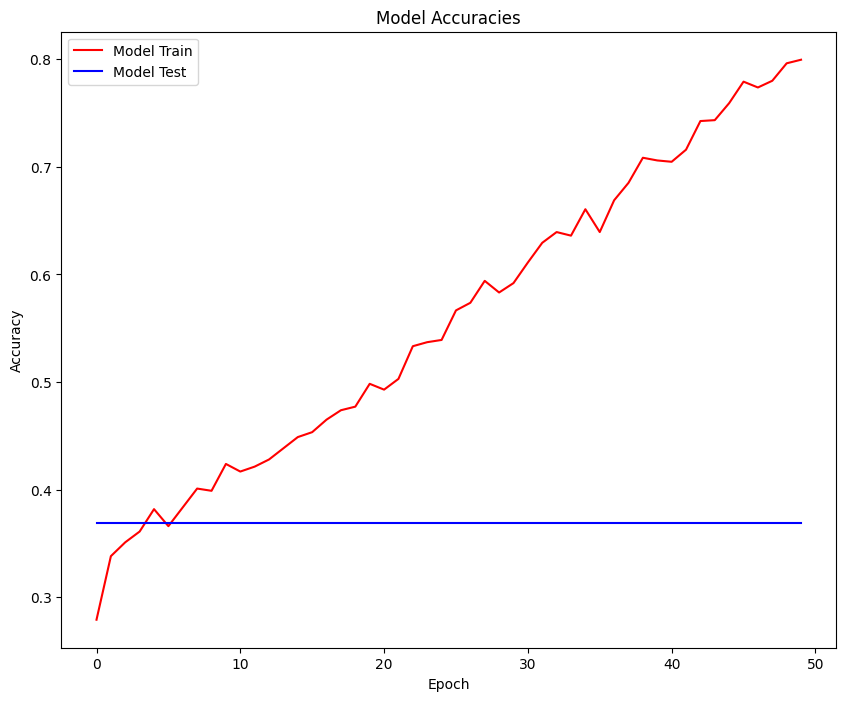

In [48]:
draw_plot('Accuracy',"Model Accuracies",train_accuracies1_[:50],test_accuracies1_[:50])

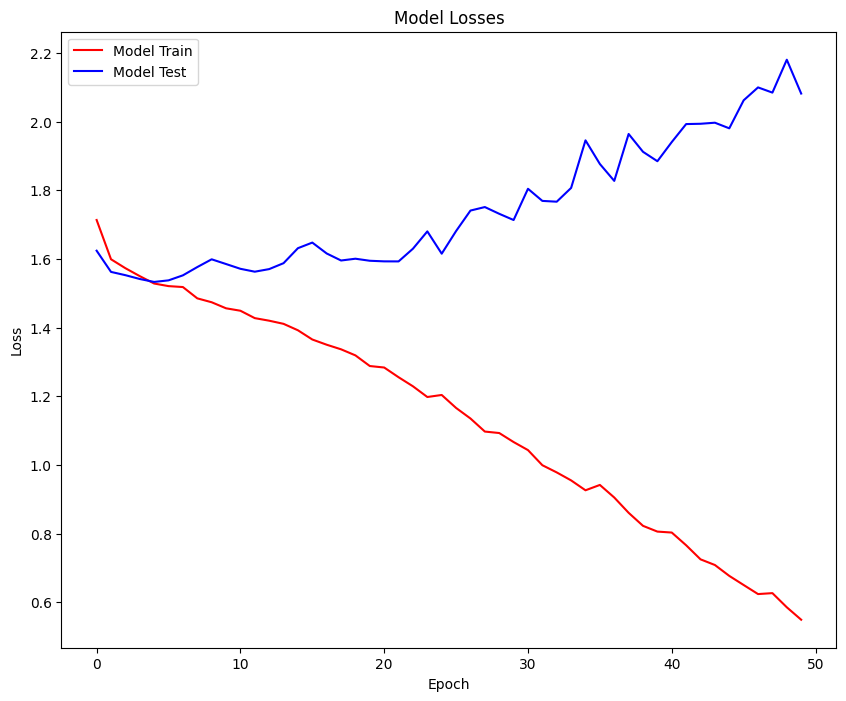

In [57]:
draw_plot('Loss',"Model Losses",train_losses1_[:50],test_losses1_[:50])

In [59]:
model_path2='/kaggle/working/EfficientNet.pt'
model_EfficientNet=EfficientNet().to(device)

In [ ]:
model1,train_losses1_, train_accuracies1_, test_losses1_, test_accuracies1_, model_test_accuracy_score1_, model_test_precision_score1_, model_test_recall_score1_, model_test_f1_score1_ = train_model(model_EfficientNet,train_dataloader,test_dataloader,50,lr,40,model_path2)


In [ ]:
plot_confusion_matrix(model1, test_dataloader)

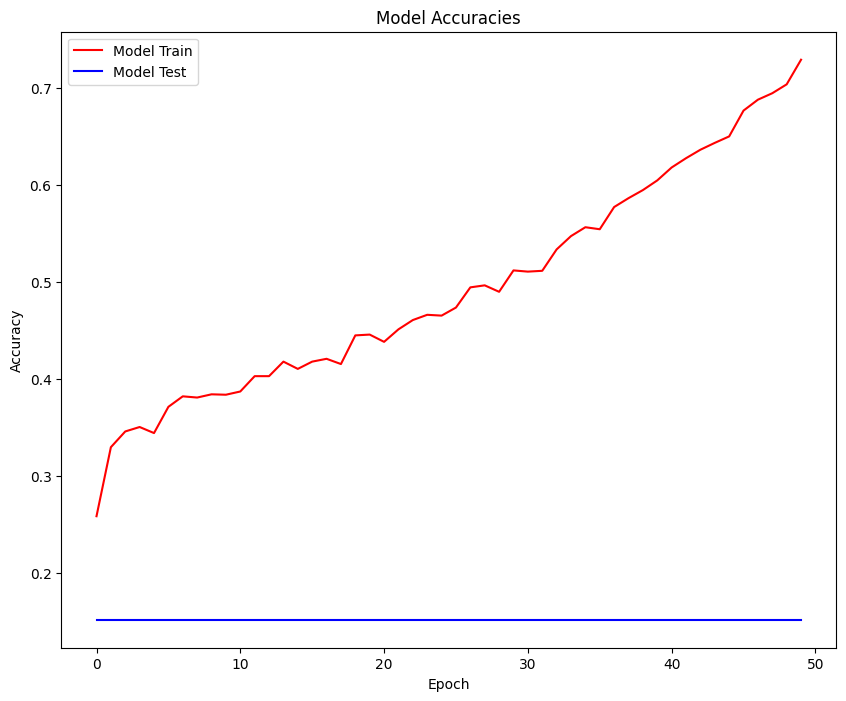

In [65]:
draw_plot('Accuracy',"Model Accuracies",train_accuracies1_,test_accuracies1_)

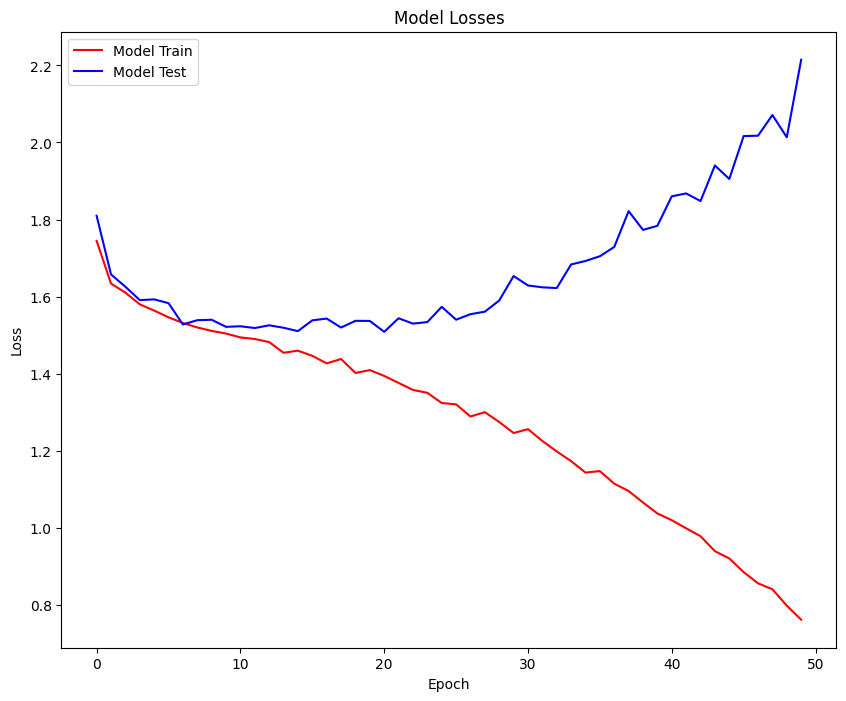

In [66]:
draw_plot_loss('Loss',"Model Losses",train_losses1_,test_losses1_)

In [43]:
model_path3='/kaggle/working/MobileNet.pt'
model_MobileNet=MobileNet().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model3,train_losses3_, train_accuracies3_, test_losses3_, test_accuracies3_, model_test_accuracy_score3_, model_test_precision_score3_, model_test_recall_score3_, model_test_f1_score3_ = train_model(model_MobileNet,train_dataloader,test_dataloader,50,lr,40,model_path3)


Epoch 1/50: 100%|██████████| 19/19 [01:40<00:00,  5.31s/batch, Loss=1.7, Accuracy=0.294] 


Epoch 1/50, Train Loss: 1.6965, Train Accuracy: 0.2937, Test Loss: 1.6298, Test Accuracy: 0.3443


Epoch 2/50: 100%|██████████| 19/19 [01:40<00:00,  5.28s/batch, Loss=1.62, Accuracy=0.328]


Epoch 2/50, Train Loss: 1.6206, Train Accuracy: 0.3278, Test Loss: 1.6118, Test Accuracy: 0.3627


Epoch 3/50: 100%|██████████| 19/19 [01:41<00:00,  5.32s/batch, Loss=1.6, Accuracy=0.325] 


Epoch 3/50, Train Loss: 1.6006, Train Accuracy: 0.3253, Test Loss: 1.5970, Test Accuracy: 0.3709


Epoch 5/50: 100%|██████████| 19/19 [01:40<00:00,  5.31s/batch, Loss=1.57, Accuracy=0.347]


Epoch 5/50, Train Loss: 1.5714, Train Accuracy: 0.3465, Test Loss: 1.5452, Test Accuracy: 0.3770


Epoch 6/50: 100%|██████████| 19/19 [01:40<00:00,  5.31s/batch, Loss=1.56, Accuracy=0.366]


Epoch 6/50, Train Loss: 1.5639, Train Accuracy: 0.3665, Test Loss: 1.5416, Test Accuracy: 0.3832


Epoch 7/50: 100%|██████████| 19/19 [01:40<00:00,  5.30s/batch, Loss=1.55, Accuracy=0.353]


Epoch 7/50, Train Loss: 1.5505, Train Accuracy: 0.3527, Test Loss: 1.5293, Test Accuracy: 0.3893


Epoch 8/50: 100%|██████████| 19/19 [01:40<00:00,  5.30s/batch, Loss=1.53, Accuracy=0.37] 


Epoch 8/50, Train Loss: 1.5324, Train Accuracy: 0.3702, Test Loss: 1.5640, Test Accuracy: 0.3504


Epoch 9/50:  68%|██████▊   | 13/19 [01:06<00:30,  5.03s/batch, Loss=1.53, Accuracy=0.383]

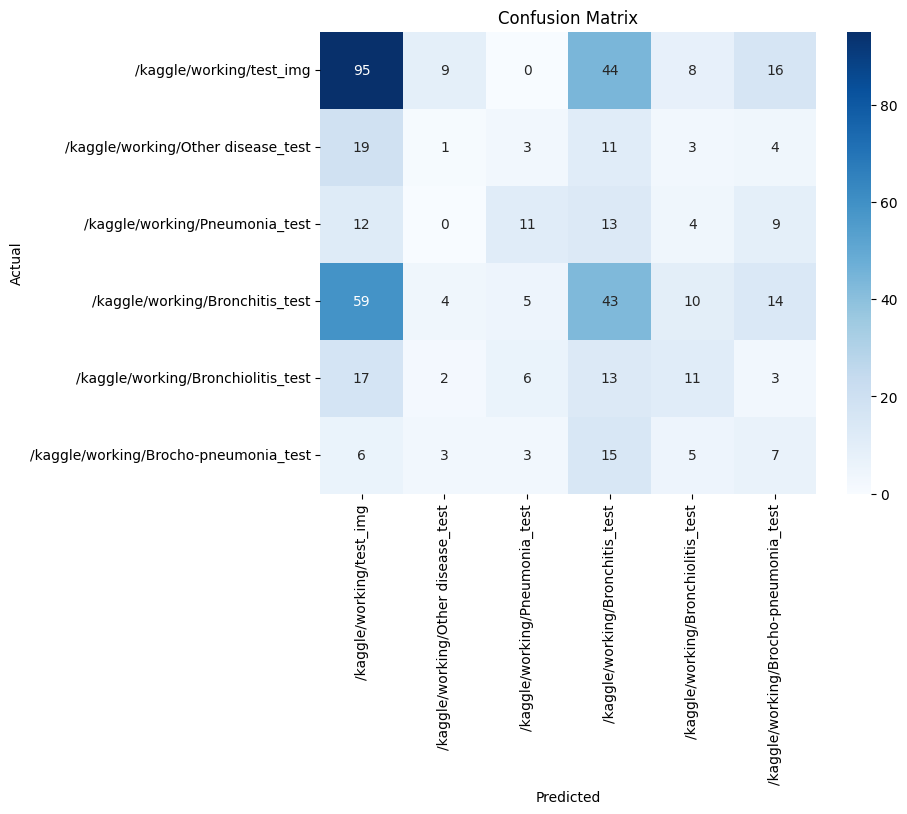

In [35]:
plot_confusion_matrix(model3,test_dataloader)

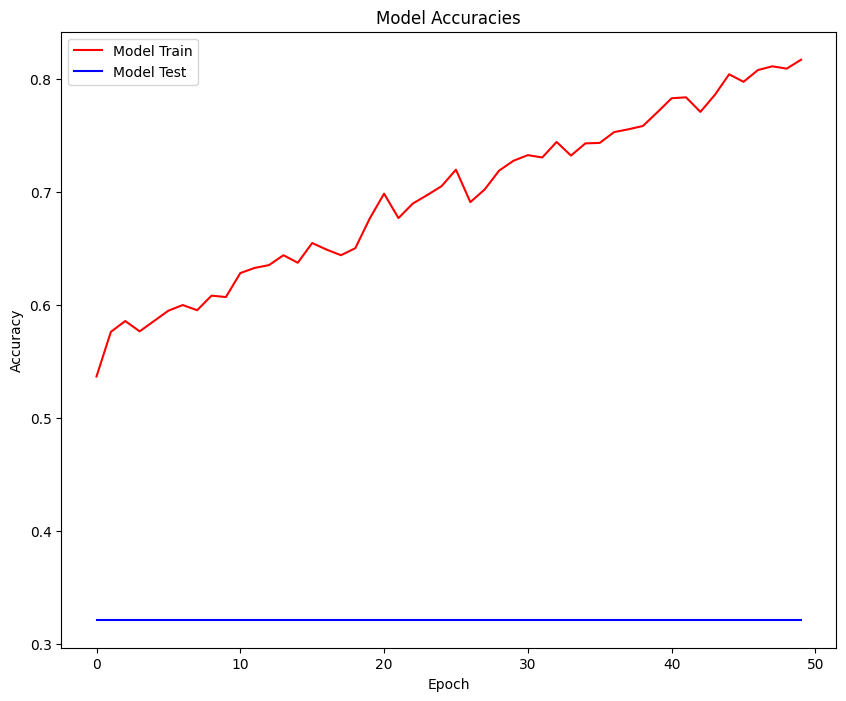

In [38]:
draw_plot('Accuracy',"Model Accuracies",train_accuracies3_,test_accuracies3_)

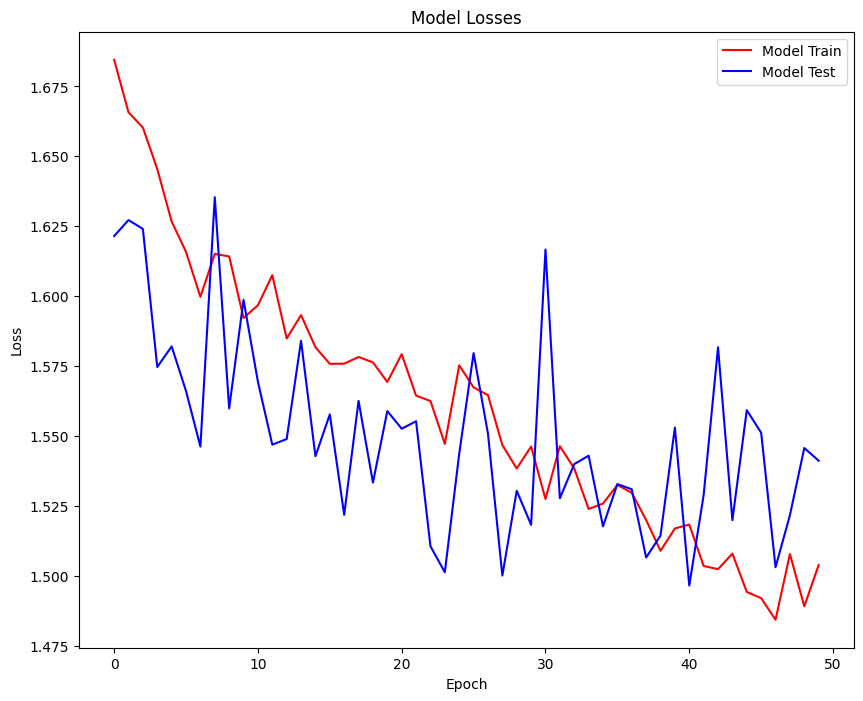

In [46]:
draw_plot_loss('Loss',"Model Losses",train_losses3_,test_losses3_)

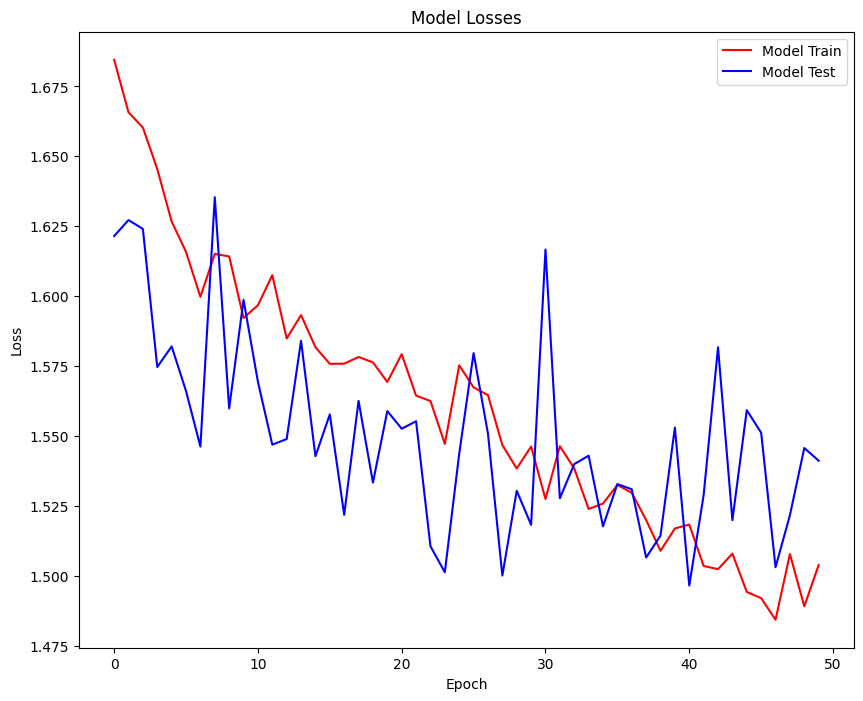

In [41]:
draw_plot_loss('Loss',"Model Losses",train_losses3_,test_losses3_)

In [36]:
model_VGG19=VGG19(num_classes=6).to(device)
model_path4='/kaggle/working/model_VGG19.pt'

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 151MB/s]  


In [37]:
model3,train_losses3_, train_accuracies3_, test_losses3_, test_accuracies3_, model_test_accuracy_score3_, model_test_precision_score3_, model_test_recall_score3_, model_test_f1_score3_ = train_model(model_VGG19,train_dataloader,test_dataloader,50,lr,40,model_path4)


Epoch 1/50: 100%|██████████| 38/38 [02:03<00:00,  3.25s/batch, Loss=1.68, Accuracy=0.272]


Epoch 1/50, Train Loss: 1.6845, Train Accuracy: 0.2720, Test Loss: 1.6215, Test Accuracy: 0.3525


Epoch 2/50: 100%|██████████| 38/38 [01:57<00:00,  3.09s/batch, Loss=1.67, Accuracy=0.302]


Epoch 2/50, Train Loss: 1.6657, Train Accuracy: 0.3024, Test Loss: 1.6272, Test Accuracy: 0.3586


Epoch 3/50: 100%|██████████| 38/38 [01:56<00:00,  3.07s/batch, Loss=1.66, Accuracy=0.307]


Epoch 3/50, Train Loss: 1.6603, Train Accuracy: 0.3074, Test Loss: 1.6241, Test Accuracy: 0.2828


Epoch 4/50: 100%|██████████| 38/38 [01:56<00:00,  3.06s/batch, Loss=1.65, Accuracy=0.298]


Epoch 4/50, Train Loss: 1.6455, Train Accuracy: 0.2978, Test Loss: 1.5747, Test Accuracy: 0.3279


Epoch 5/50: 100%|██████████| 38/38 [01:57<00:00,  3.09s/batch, Loss=1.63, Accuracy=0.328]


Epoch 5/50, Train Loss: 1.6267, Train Accuracy: 0.3278, Test Loss: 1.5821, Test Accuracy: 0.3402


Epoch 6/50: 100%|██████████| 38/38 [01:57<00:00,  3.08s/batch, Loss=1.62, Accuracy=0.344]


Epoch 6/50, Train Loss: 1.6158, Train Accuracy: 0.3436, Test Loss: 1.5661, Test Accuracy: 0.3402


Epoch 7/50: 100%|██████████| 38/38 [01:57<00:00,  3.10s/batch, Loss=1.6, Accuracy=0.336] 


Epoch 7/50, Train Loss: 1.5998, Train Accuracy: 0.3357, Test Loss: 1.5463, Test Accuracy: 0.3545


Epoch 8/50: 100%|██████████| 38/38 [01:57<00:00,  3.08s/batch, Loss=1.62, Accuracy=0.334]


Epoch 8/50, Train Loss: 1.6151, Train Accuracy: 0.3340, Test Loss: 1.6354, Test Accuracy: 0.3422


Epoch 9/50: 100%|██████████| 38/38 [01:56<00:00,  3.07s/batch, Loss=1.61, Accuracy=0.315]


Epoch 9/50, Train Loss: 1.6142, Train Accuracy: 0.3149, Test Loss: 1.5599, Test Accuracy: 0.3484


Epoch 10/50: 100%|██████████| 38/38 [01:56<00:00,  3.07s/batch, Loss=1.59, Accuracy=0.332]


Epoch 10/50, Train Loss: 1.5922, Train Accuracy: 0.3319, Test Loss: 1.5987, Test Accuracy: 0.3340


Epoch 11/50: 100%|██████████| 38/38 [01:57<00:00,  3.08s/batch, Loss=1.6, Accuracy=0.329] 


Epoch 11/50, Train Loss: 1.5968, Train Accuracy: 0.3290, Test Loss: 1.5694, Test Accuracy: 0.3320


Epoch 12/50: 100%|██████████| 38/38 [01:57<00:00,  3.09s/batch, Loss=1.61, Accuracy=0.339]


Epoch 12/50, Train Loss: 1.6075, Train Accuracy: 0.3390, Test Loss: 1.5470, Test Accuracy: 0.3525


Epoch 13/50: 100%|██████████| 38/38 [01:57<00:00,  3.08s/batch, Loss=1.58, Accuracy=0.341]


Epoch 13/50, Train Loss: 1.5849, Train Accuracy: 0.3407, Test Loss: 1.5490, Test Accuracy: 0.3545


Epoch 14/50: 100%|██████████| 38/38 [01:55<00:00,  3.05s/batch, Loss=1.59, Accuracy=0.334]


Epoch 14/50, Train Loss: 1.5933, Train Accuracy: 0.3344, Test Loss: 1.5841, Test Accuracy: 0.3586


Epoch 15/50: 100%|██████████| 38/38 [01:56<00:00,  3.07s/batch, Loss=1.58, Accuracy=0.348]


Epoch 15/50, Train Loss: 1.5818, Train Accuracy: 0.3478, Test Loss: 1.5428, Test Accuracy: 0.3607


Epoch 16/50: 100%|██████████| 38/38 [01:54<00:00,  3.02s/batch, Loss=1.58, Accuracy=0.355]


Epoch 16/50, Train Loss: 1.5758, Train Accuracy: 0.3552, Test Loss: 1.5578, Test Accuracy: 0.3832


Epoch 17/50: 100%|██████████| 38/38 [01:55<00:00,  3.04s/batch, Loss=1.58, Accuracy=0.335]


Epoch 17/50, Train Loss: 1.5759, Train Accuracy: 0.3353, Test Loss: 1.5219, Test Accuracy: 0.3566


Epoch 18/50: 100%|██████████| 38/38 [01:55<00:00,  3.03s/batch, Loss=1.58, Accuracy=0.34] 


Epoch 18/50, Train Loss: 1.5783, Train Accuracy: 0.3403, Test Loss: 1.5626, Test Accuracy: 0.3607


Epoch 19/50: 100%|██████████| 38/38 [01:55<00:00,  3.04s/batch, Loss=1.58, Accuracy=0.361]


Epoch 19/50, Train Loss: 1.5764, Train Accuracy: 0.3611, Test Loss: 1.5334, Test Accuracy: 0.3648


Epoch 20/50: 100%|██████████| 38/38 [01:55<00:00,  3.04s/batch, Loss=1.57, Accuracy=0.349]


Epoch 20/50, Train Loss: 1.5694, Train Accuracy: 0.3494, Test Loss: 1.5589, Test Accuracy: 0.3607


Epoch 21/50: 100%|██████████| 38/38 [01:55<00:00,  3.04s/batch, Loss=1.58, Accuracy=0.35] 


Epoch 21/50, Train Loss: 1.5793, Train Accuracy: 0.3502, Test Loss: 1.5527, Test Accuracy: 0.3525


Epoch 22/50: 100%|██████████| 38/38 [01:56<00:00,  3.06s/batch, Loss=1.56, Accuracy=0.362]


Epoch 22/50, Train Loss: 1.5645, Train Accuracy: 0.3619, Test Loss: 1.5553, Test Accuracy: 0.3586


Epoch 23/50: 100%|██████████| 38/38 [01:57<00:00,  3.08s/batch, Loss=1.56, Accuracy=0.366]


Epoch 23/50, Train Loss: 1.5626, Train Accuracy: 0.3656, Test Loss: 1.5106, Test Accuracy: 0.3811


Epoch 24/50: 100%|██████████| 38/38 [01:54<00:00,  3.01s/batch, Loss=1.55, Accuracy=0.376]


Epoch 24/50, Train Loss: 1.5472, Train Accuracy: 0.3765, Test Loss: 1.5013, Test Accuracy: 0.3852


Epoch 25/50: 100%|██████████| 38/38 [01:55<00:00,  3.03s/batch, Loss=1.58, Accuracy=0.357]


Epoch 25/50, Train Loss: 1.5753, Train Accuracy: 0.3573, Test Loss: 1.5437, Test Accuracy: 0.3566


Epoch 26/50: 100%|██████████| 38/38 [01:54<00:00,  3.01s/batch, Loss=1.57, Accuracy=0.351]


Epoch 26/50, Train Loss: 1.5674, Train Accuracy: 0.3515, Test Loss: 1.5796, Test Accuracy: 0.3852


Epoch 27/50: 100%|██████████| 38/38 [01:53<00:00,  3.00s/batch, Loss=1.56, Accuracy=0.358]


Epoch 27/50, Train Loss: 1.5647, Train Accuracy: 0.3582, Test Loss: 1.5509, Test Accuracy: 0.3586


Epoch 28/50: 100%|██████████| 38/38 [01:53<00:00,  3.00s/batch, Loss=1.55, Accuracy=0.367]


Epoch 28/50, Train Loss: 1.5468, Train Accuracy: 0.3669, Test Loss: 1.5002, Test Accuracy: 0.4016


Epoch 29/50: 100%|██████████| 38/38 [01:53<00:00,  3.00s/batch, Loss=1.54, Accuracy=0.362]


Epoch 29/50, Train Loss: 1.5384, Train Accuracy: 0.3623, Test Loss: 1.5305, Test Accuracy: 0.3648


Epoch 30/50: 100%|██████████| 38/38 [01:53<00:00,  2.99s/batch, Loss=1.55, Accuracy=0.379]


Epoch 30/50, Train Loss: 1.5463, Train Accuracy: 0.3790, Test Loss: 1.5183, Test Accuracy: 0.3648


Epoch 31/50: 100%|██████████| 38/38 [01:54<00:00,  3.00s/batch, Loss=1.53, Accuracy=0.386]


Epoch 31/50, Train Loss: 1.5275, Train Accuracy: 0.3860, Test Loss: 1.6167, Test Accuracy: 0.3648


Epoch 32/50: 100%|██████████| 38/38 [01:53<00:00,  3.00s/batch, Loss=1.55, Accuracy=0.358]


Epoch 32/50, Train Loss: 1.5464, Train Accuracy: 0.3577, Test Loss: 1.5278, Test Accuracy: 0.3832


Epoch 33/50: 100%|██████████| 38/38 [01:54<00:00,  3.00s/batch, Loss=1.54, Accuracy=0.369]


Epoch 33/50, Train Loss: 1.5384, Train Accuracy: 0.3686, Test Loss: 1.5400, Test Accuracy: 0.3525


Epoch 34/50: 100%|██████████| 38/38 [01:53<00:00,  3.00s/batch, Loss=1.52, Accuracy=0.381]


Epoch 34/50, Train Loss: 1.5240, Train Accuracy: 0.3806, Test Loss: 1.5430, Test Accuracy: 0.3566


Epoch 35/50: 100%|██████████| 38/38 [01:53<00:00,  2.98s/batch, Loss=1.53, Accuracy=0.371]


Epoch 35/50, Train Loss: 1.5259, Train Accuracy: 0.3706, Test Loss: 1.5177, Test Accuracy: 0.4201


Epoch 36/50: 100%|██████████| 38/38 [01:54<00:00,  3.00s/batch, Loss=1.53, Accuracy=0.382]


Epoch 36/50, Train Loss: 1.5326, Train Accuracy: 0.3823, Test Loss: 1.5329, Test Accuracy: 0.3975


Epoch 37/50: 100%|██████████| 38/38 [01:54<00:00,  3.01s/batch, Loss=1.53, Accuracy=0.371]


Epoch 37/50, Train Loss: 1.5297, Train Accuracy: 0.3706, Test Loss: 1.5310, Test Accuracy: 0.3750


Epoch 38/50: 100%|██████████| 38/38 [01:53<00:00,  2.98s/batch, Loss=1.52, Accuracy=0.378]


Epoch 38/50, Train Loss: 1.5200, Train Accuracy: 0.3777, Test Loss: 1.5066, Test Accuracy: 0.4078


Epoch 39/50: 100%|██████████| 38/38 [01:53<00:00,  2.99s/batch, Loss=1.51, Accuracy=0.368]


Epoch 39/50, Train Loss: 1.5090, Train Accuracy: 0.3681, Test Loss: 1.5145, Test Accuracy: 0.3648


Epoch 40/50: 100%|██████████| 38/38 [01:56<00:00,  3.07s/batch, Loss=1.52, Accuracy=0.388]


Epoch 40/50, Train Loss: 1.5170, Train Accuracy: 0.3877, Test Loss: 1.5531, Test Accuracy: 0.3443


Epoch 41/50: 100%|██████████| 38/38 [01:56<00:00,  3.06s/batch, Loss=1.52, Accuracy=0.381]


Epoch 41/50, Train Loss: 1.5184, Train Accuracy: 0.3814, Test Loss: 1.4966, Test Accuracy: 0.3893


Epoch 42/50: 100%|██████████| 38/38 [01:56<00:00,  3.06s/batch, Loss=1.5, Accuracy=0.385] 


Epoch 42/50, Train Loss: 1.5036, Train Accuracy: 0.3852, Test Loss: 1.5289, Test Accuracy: 0.3832


Epoch 43/50: 100%|██████████| 38/38 [01:56<00:00,  3.06s/batch, Loss=1.5, Accuracy=0.388] 


Epoch 43/50, Train Loss: 1.5024, Train Accuracy: 0.3877, Test Loss: 1.5817, Test Accuracy: 0.3750


Epoch 44/50: 100%|██████████| 38/38 [01:56<00:00,  3.08s/batch, Loss=1.51, Accuracy=0.389]


Epoch 44/50, Train Loss: 1.5080, Train Accuracy: 0.3894, Test Loss: 1.5200, Test Accuracy: 0.4057


Epoch 45/50: 100%|██████████| 38/38 [01:54<00:00,  3.02s/batch, Loss=1.49, Accuracy=0.392]


Epoch 45/50, Train Loss: 1.4943, Train Accuracy: 0.3923, Test Loss: 1.5593, Test Accuracy: 0.3730


Epoch 46/50: 100%|██████████| 38/38 [01:56<00:00,  3.07s/batch, Loss=1.49, Accuracy=0.387]


Epoch 46/50, Train Loss: 1.4921, Train Accuracy: 0.3873, Test Loss: 1.5512, Test Accuracy: 0.3791


Epoch 47/50: 100%|██████████| 38/38 [01:55<00:00,  3.03s/batch, Loss=1.48, Accuracy=0.393]


Epoch 47/50, Train Loss: 1.4844, Train Accuracy: 0.3927, Test Loss: 1.5031, Test Accuracy: 0.4098


Epoch 48/50: 100%|██████████| 38/38 [01:54<00:00,  3.01s/batch, Loss=1.51, Accuracy=0.384]


Epoch 48/50, Train Loss: 1.5078, Train Accuracy: 0.3839, Test Loss: 1.5217, Test Accuracy: 0.4016


Epoch 49/50: 100%|██████████| 38/38 [01:54<00:00,  3.02s/batch, Loss=1.49, Accuracy=0.4]  


Epoch 49/50, Train Loss: 1.4892, Train Accuracy: 0.3998, Test Loss: 1.5458, Test Accuracy: 0.3832


Epoch 50/50: 100%|██████████| 38/38 [01:57<00:00,  3.09s/batch, Loss=1.5, Accuracy=0.387] 


Epoch 50/50, Train Loss: 1.5039, Train Accuracy: 0.3873, Test Loss: 1.5412, Test Accuracy: 0.3770
Classification Report:
               precision    recall  f1-score   support

           0     0.5508    0.3779    0.4483       172
           1     0.0000    0.0000    0.0000        41
           2     0.6000    0.1224    0.2034        49
           3     0.3377    0.7630    0.4682       135
           4     0.1750    0.1346    0.1522        52
           5     0.2000    0.0769    0.1111        39

    accuracy                         0.3770       488
   macro avg     0.3106    0.2458    0.2305       488
weighted avg     0.3825    0.3770    0.3330       488

Test Accuracy Score: 0.3770491803278688
Test Precision Score: 0.38245066935715294
Test Recall Score: 0.3770491803278688
Test F1 Score: 0.3330337545838463


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

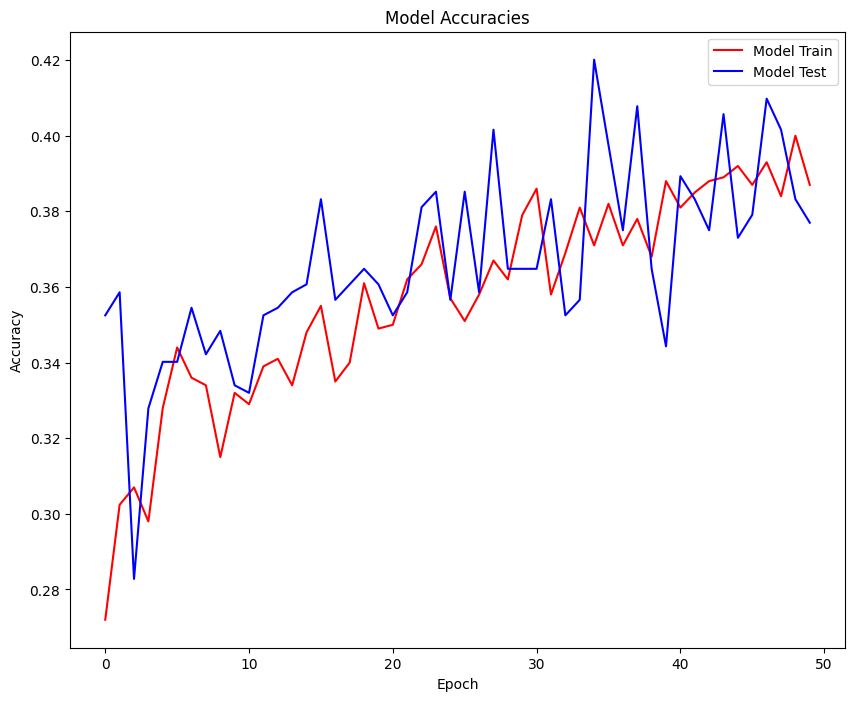

In [12]:
draw_plot('Accuracy',"Model Accuracies",train_accuracies3_,test_accuracies3_)

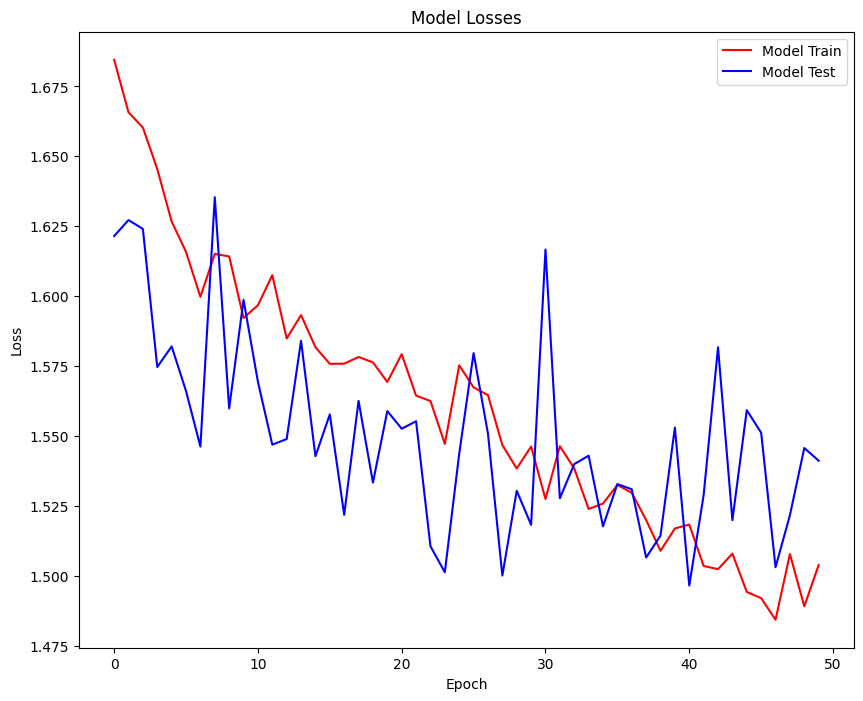

In [45]:
draw_plot_loss('Loss',"Model Losses",train_losses3_,test_losses3_)

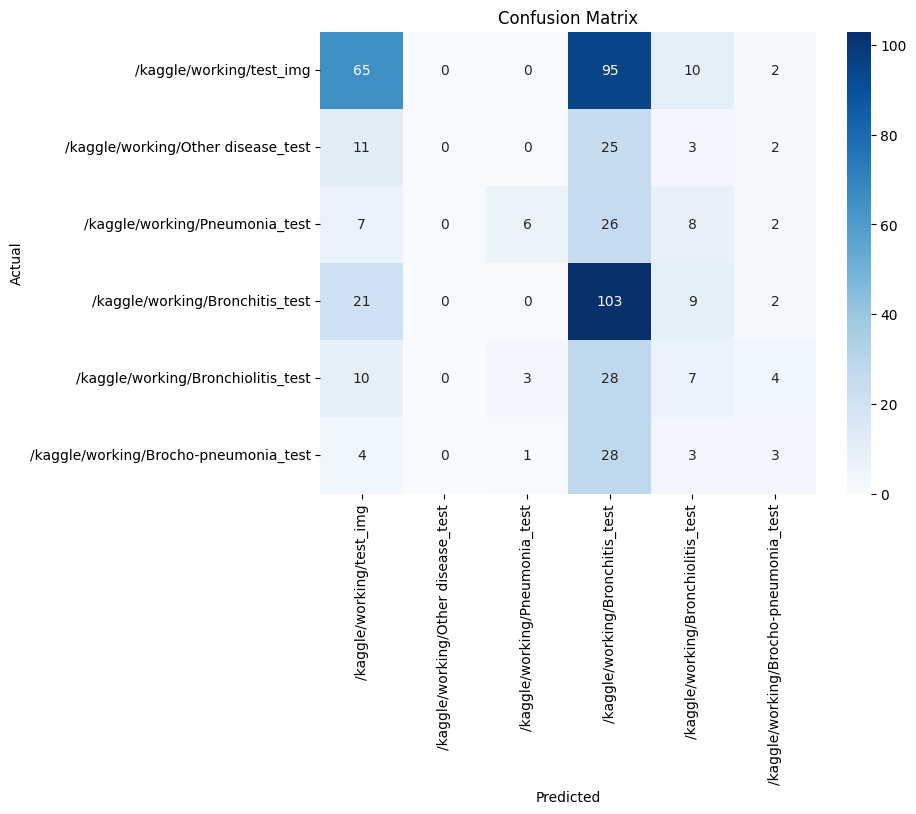

In [44]:
plot_confusion_matrix(model3, test_dataloader)